In [9]:
import os

os.system("rm -rf test train")

0

In [10]:
import cv2
import os
import random

def extract_frames(video_path):
    """Extracts all frames from a given video file."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def save_sequence(sequence, output_dir, video_name, seq_index):
    """Saves a sequence of frames into a dedicated subfolder."""
    seq_folder = os.path.join(output_dir, f"{video_name}_seq_{seq_index}")
    os.makedirs(seq_folder, exist_ok=True)
    for i, frame in enumerate(sequence):
        frame_path = os.path.join(seq_folder, f"frame_{i}.jpg")
        cv2.imwrite(frame_path, frame)

def generate_dataset(input_folder, train_folder, test_folder, num_interpolated=1, train_ratio=0.8):
    """
    Processes each video in the input folder.

    For each video, a sliding window of length (num_interpolated + 2) is used
    to generate sequences where the first and last frames are the inputs for interpolation,
    and the frames in between are used as ground truth.

    Each sequence is randomly assigned to train or test.
    """
    # The total sequence length includes the starting and ending frames
    sequence_length = num_interpolated + 2

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".mp4"):
            video_path = os.path.join(input_folder, filename)
            video_name = os.path.splitext(filename)[0]
            frames = extract_frames(video_path)
            total_frames = len(frames)
            seq_index = 0
            # Slide a window over the frames to generate sequences
            for i in range(total_frames - sequence_length + 1):
                sequence = frames[i:i + sequence_length]
                # Randomly assign the sequence to training or testing set
                if random.random() < train_ratio:
                    save_sequence(sequence, train_folder, video_name, seq_index)
                else:
                    save_sequence(sequence, test_folder, video_name, seq_index)
                seq_index += 1

if __name__ == "__main__":
    input_folder = "input"    # Folder containing your mp4 videos
    train_folder = "train"    # Output folder for training sequences
    test_folder = "test"      # Output folder for testing sequences
    generate_dataset(input_folder, train_folder, test_folder)


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
IMG_SIZE = (128, 128)     # Resize frames to a fixed resolution
NUM_INTERPOLATED = 1      # Number of frames to interpolate between the start and end
BATCH_SIZE = 32
EPOCHS = 10

def load_sequence(seq_path):
    """
    Loads and sorts frames from a sequence folder.
    Assumes frame filenames are like "frame_0.jpg", "frame_1.jpg", etc.
    """
    frames = []
    # Sort filenames to ensure correct order
    file_list = sorted([f for f in os.listdir(seq_path) if f.endswith(".jpg") and f.startswith("frame_")])
    for filename in file_list:
        img_path = os.path.join(seq_path, filename)
        # Read using OpenCV, convert from BGR to RGB, and resize
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype(np.float32) / 255.0
        frames.append(img)
    return frames

def process_sequence(frames):
    """
    Given a list of frames, forms:
      - Input: concatenated first and last frames (shape: H x W x 6)
      - Target: concatenated intermediate frames (shape: H x W x (NUM_INTERPOLATED*3))
    """
    # Ensure there are enough frames
    if len(frames) < NUM_INTERPOLATED + 2:
        return None, None
    input_frames = [frames[0], frames[-1]]
    target_frames = frames[1:-1]
    # Concatenate along the channel axis
    input_tensor = np.concatenate(input_frames, axis=-1)
    target_tensor = np.concatenate(target_frames, axis=-1)
    return input_tensor, target_tensor

def dataset_from_folder(folder):
    """
    Builds a tf.data.Dataset from a folder containing sequence subfolders.
    """
    inputs, targets = [], []
    for seq_folder in os.listdir(folder):
        seq_path = os.path.join(folder, seq_folder)
        if os.path.isdir(seq_path):
            frames = load_sequence(seq_path)
            inp, tar = process_sequence(frames)
            if inp is not None and tar is not None:
                inputs.append(inp)
                targets.append(tar)
    dataset = tf.data.Dataset.from_tensor_slices((np.array(inputs), np.array(targets)))
    return dataset

def build_unet_model(input_shape, num_interpolated):
    """
    Builds a U-Net–style model.

    Input shape: (H, W, 6) corresponding to concatenated start and end frames.
    Output shape: (H, W, num_interpolated * 3) representing stacked intermediate frames.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder block 1
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Encoder block 2
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Encoder block 3
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Encoder block 4
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder block 1
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    # Decoder block 2
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    # Decoder block 3
    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    # Decoder block 4
    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_interpolated * 3, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model


# Prepare datasets
train_folder = "train"  # Folder containing training sequence subfolders
test_folder = "test"    # Folder containing testing sequence subfolders

train_ds = dataset_from_folder(train_folder)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = dataset_from_folder(test_folder)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build and compile the U-Net model:
input_shape = (IMG_SIZE[1], IMG_SIZE[0], 6)  # (height, width, channels)
model = build_unet_model(input_shape, NUM_INTERPOLATED)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train as before:
print("Starting training with U-Net model...")
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

# Evaluate
print("Evaluating on test data...")
loss, mae = model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test MAE:", mae)

# (Optional) Make predictions on test samples
for inputs, targets in test_ds.take(1):
    predictions = model.predict(inputs)
    print("Predictions shape:", predictions.shape)

Starting training with U-Net model...
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 412s 67s/step - loss: 0.0528 - mae: 0.1875 - val_loss: 0.0458 - val_mae: 0.1721
Epoch 2/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 8:49 106s/step - loss: 0.0446 - mae: 0.1693

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


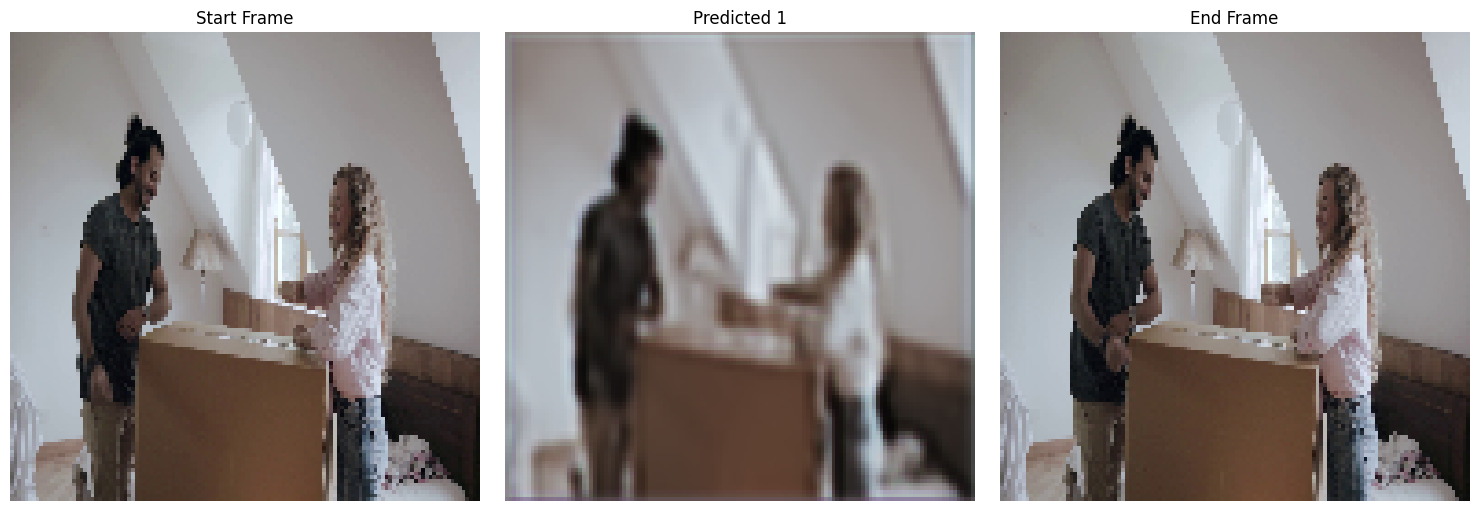

In [12]:
import matplotlib.pyplot as plt
import cv2

def split_frames(input_tensor, target_tensor, predicted_tensor, num_interpolated):
    """
    Splits the concatenated frames into individual images.
    - input_tensor: shape (H, W, 6) → first 3 channels are start frame, last 3 channels are end frame.
    - target_tensor and predicted_tensor: shape (H, W, num_interpolated*3).
    Returns: start_frame, list of ground truth intermediate frames, list of predicted frames, end_frame.
    """
    start_frame = input_tensor[..., :3]
    end_frame = input_tensor[..., 3:]
    gt_frames = [target_tensor[..., i*3:(i+1)*3] for i in range(num_interpolated)]
    pred_frames = [predicted_tensor[..., i*3:(i+1)*3] for i in range(num_interpolated)]
    return start_frame, gt_frames, pred_frames, end_frame

# Evaluate one sample from the test dataset.
for inputs, targets in test_ds.take(1):
    # Run inference.
    predictions = model.predict(inputs)
    # Select the first sample from the batch.
    sample_input = inputs[0]
    sample_target = targets[0]
    sample_prediction = predictions[0]

    # Split the frames.
    start_frame, gt_frames, pred_frames, end_frame = split_frames(
        sample_input, sample_target, sample_prediction, NUM_INTERPOLATED
    )

    # ---------------------------
    # Option 1: Visualize using matplotlib.
    # ---------------------------
    num_subplots = NUM_INTERPOLATED + 2  # start + predicted frames + end
    plt.figure(figsize=(15, 5))

    plt.subplot(1, num_subplots, 1)
    plt.imshow(start_frame)
    plt.title("Start Frame")
    plt.axis("off")

    for i in range(NUM_INTERPOLATED):
        plt.subplot(1, num_subplots, i + 2)
        plt.imshow(pred_frames[i])
        plt.title(f"Predicted {i+1}")
        plt.axis("off")

    plt.subplot(1, num_subplots, num_subplots)
    plt.imshow(end_frame)
    plt.title("End Frame")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Option 2: Save a short video showing the sequence.
    # ---------------------------
    # def save_video(frames, filename, fps=1):
    #     """
    #     Saves a list of frames (assumed to be in [0,1] float format, RGB) as an MP4 video.
    #     """
    #     height, width, _ = frames[0].shape
    #     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #     video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))
    #     for frame in frames:
    #         # Convert from [0,1] float to uint8 [0,255] and from RGB to BGR.
    #         frame_uint8 = (frame * 255).astype('uint8')
    #         frame_bgr = cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2BGR)
    #         video_writer.write(frame_bgr)
    #     video_writer.release()

    # # Create a list of frames for the video: start, each predicted frame, and end.
    # video_frames = [start_frame] + pred_frames + [end_frame]
    # video_filename = "result_video.mp4"
    # save_video(video_frames, video_filename, fps=1)
    # print("Video saved as", video_filename)

    # # Since we're evaluating one sample, break after processing.
    # break


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


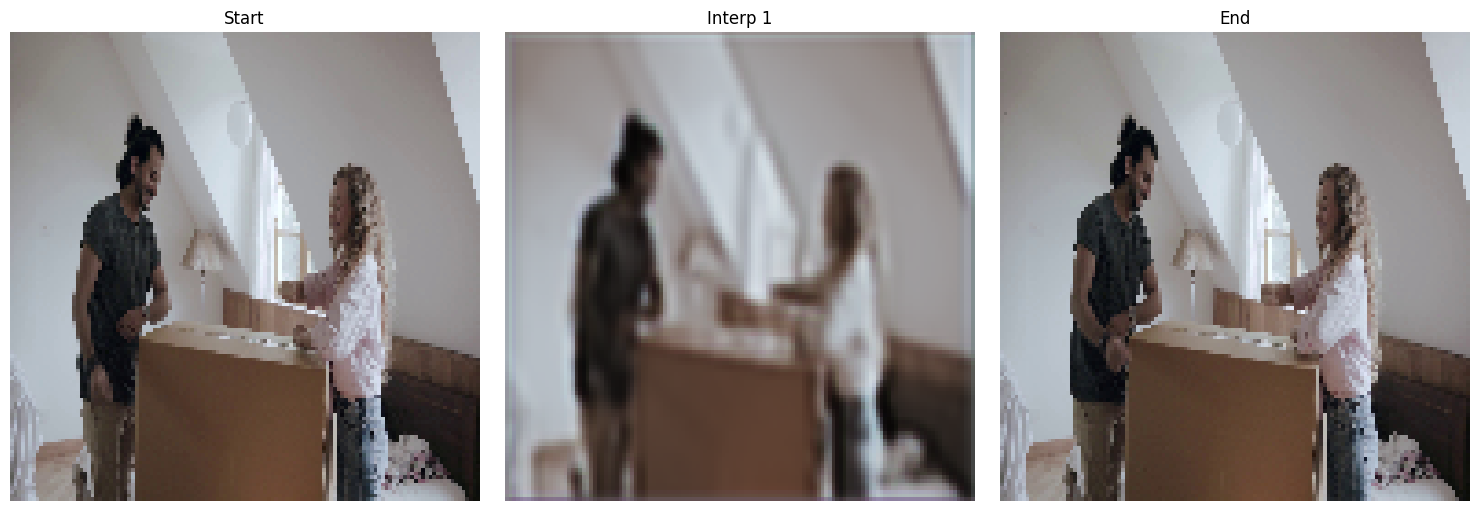

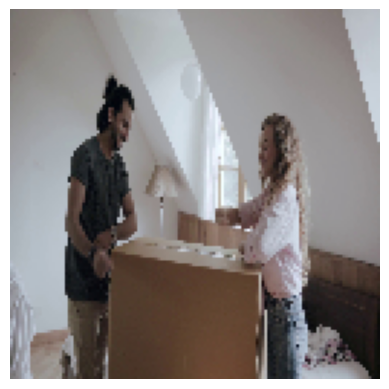

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming the following variables are defined from inference:
# - start_frame: numpy array (H x W x 3)
# - pred_frames: list of NUM_INTERPOLATED numpy arrays (each H x W x 3)
# - end_frame: numpy array (H x W x 3)
# - video_frames: list combining the above in order: [start_frame] + pred_frames + [end_frame]

# For example, reuse the split_frames function from previous code:
def split_frames(input_tensor, target_tensor, predicted_tensor, num_interpolated):
    """
    Splits the concatenated frames into individual images.
    - input_tensor: shape (H, W, 6) → first 3 channels are start frame, last 3 channels are end frame.
    - target_tensor and predicted_tensor: shape (H, W, num_interpolated*3).
    Returns: start_frame, list of ground truth intermediate frames, list of predicted frames, end_frame.
    """
    start_frame = input_tensor[..., :3]
    end_frame = input_tensor[..., 3:]
    gt_frames = [target_tensor[..., i*3:(i+1)*3] for i in range(num_interpolated)]
    pred_frames = [predicted_tensor[..., i*3:(i+1)*3] for i in range(num_interpolated)]
    return start_frame, gt_frames, pred_frames, end_frame

# Example: Process one test sample
for inputs, targets in test_ds.take(1):
    predictions = model.predict(inputs)
    sample_input = inputs[0]
    sample_target = targets[0]
    sample_prediction = predictions[0]

    start_frame, gt_frames, pred_frames, end_frame = split_frames(
        sample_input, sample_target, sample_prediction, NUM_INTERPOLATED
    )
    # Create a list of frames for display
    video_frames = [start_frame] + pred_frames + [end_frame]
    break

# --- Option 1: Display Frames in a Grid ---
num_frames = len(video_frames)
plt.figure(figsize=(15, 5))
for i, frame in enumerate(video_frames):
    plt.subplot(1, num_frames, i+1)
    plt.imshow(frame)
    plt.axis("off")
    if i == 0:
        plt.title("Start")
    elif i == num_frames-1:
        plt.title("End")
    else:
        plt.title(f"Interp {i}")
plt.tight_layout()
plt.show()

# --- Option 2: Create an Inline Animation in the Notebook ---
fig, ax = plt.subplots()
im = ax.imshow(video_frames[0])
ax.axis("off")

def update(i):
    im.set_data(video_frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(video_frames), interval=500, blit=True)
# Display the animation inline
HTML(ani.to_jshtml())
